# Data Preparation

## Packages

In [1]:
import os
import winsound
import numpy as np
import pandas as pd
#import modin.pandas as pd
import datetime as dt
from tqdm import tqdm
tqdm.pandas()
from multiprocessing import  Pool
import time
import imblearn

import math, collections
from scipy.stats import linregress

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_date_hour(df):    
    
    weekday_val = []
    hour = []
    
    for i in tqdm(df['DateTime']):
        date_val  = dt.datetime.strptime(i, '%Y%m%d %H:%M:%S.%f')
        weekday_val.append(date_val.weekday())
        hour.append(date_val.hour)

    df['weekday'] = weekday_val
    df['hour'] = hour
    return(df)

In [3]:
def get_slope(y_axis):
    global data
    ma_len = len(y_axis)
    
    x_axis = []
    for i in range(ma_len):
        x_axis.append(1 + ((i+1) * 0.0001 * 0.1))
    
    slope_tick, intercept, _, _, _ = linregress(x_axis, y_axis)
    slope_tick = math.degrees(math.atan(slope_tick))
    
    return(slope_tick)

In [4]:
def chunk_ticks(df, number_of_ticks):   
    global data
    
    df['tick'] = (df['Bid'] + df['Ask'])/2
    df['spread'] = df['Ask'] - df['Bid']
    df = df[['weekday', 'hour','tick', 'spread']]
    
    temp_df = pd.DataFrame()
    tick_avg = []
    spread_avg = []
    tick_sd = []
    tick_act = []
    candle_height = []
    candle_max_val = []
    candle_min_val = []
    weekday = []
    hour = []
    
    for i in tqdm(range(0,len(df),number_of_ticks)):
        tick_list = list(df['tick'][i:i+number_of_ticks])
        spread_list = list(df['spread'][i:i+number_of_ticks])
        weekday_list = list(df['weekday'][i:i+number_of_ticks])
        hour_list = list(df['hour'][i:i+number_of_ticks])
        
        tick_act.append(tick_list[-1])              
        temp = list(pd.DataFrame(tick_list).ewm(span=len(tick_list)).mean()[0])[len(tick_list) - 1]
        tick_avg.append(temp)

        spread_avg.append(np.mean(spread_list))
        tick_sd.append(np.std(tick_list))
        candle_height.append(np.max(tick_list) - np.min(tick_list))
        candle_max_val.append(np.max(tick_list))
        candle_min_val.append(np.min(tick_list))
        weekday.append(weekday_list[-1])
        hour.append(hour_list[-1])
        
    temp_df['weekday']      =  weekday
    temp_df['hour']      = hour
    temp_df['tick_act']      = tick_act      
    temp_df['tick_avg']      = tick_avg  
    temp_df['spread_avg']    = spread_avg  
    temp_df['tick_sd']       = tick_sd  
    temp_df['candle_height'] = candle_height
    temp_df['candle_max_val'] = candle_max_val
    temp_df['candle_min_val'] = candle_min_val
    
    return(temp_df)

In [5]:
def before_sma():
    global data    
    data['ssma_list'].append(val)    
    return()

def after_sma():
    global data
    
    data['ssma_list'].popleft()
    data['ssma_list'].append(val)
    data['sema'] = list(pd.DataFrame(list(data['ssma_list'])).ewm(span=data['sma_len']).mean()[0])[data['sma_len'] - 1]
    
    if len(data['sema_ready']) < 2:
        data['sema_ready'].append(data['sema'])
        data['sema_diff'] = np.nan

    elif len(data['sema_ready']) > 1:
        data['sema_ready'].popleft()
        data['sema_ready'].append(data['sema'])
        data['sema_diff'] = data['sema_ready'][-1] - data['sema_ready'][len(data['sema_ready'])-2]
    
    return()

def before_lma():
    global data    
    data['lsma_list'].append(val)    
    return()

def after_lma():
    global data
    
    data['lsma_list'].popleft()
    data['lsma_list'].append(val)
    data['lema'] = list(pd.DataFrame(list(data['lsma_list'])).ewm(span=data['lma_len']).mean()[0])[data['lma_len'] - 1]
    
    if len(data['lema_ready']) < 2:
        data['lema_ready'].append(data['lema'])
        data['lema_diff'] = np.nan

    elif len(data['lema_ready']) > 1:
        data['lema_ready'].popleft()
        data['lema_ready'].append(data['lema'])
        data['lema_diff'] = data['lema_ready'][-1] - data['lema_ready'][len(data['lema_ready'])-2]
    
    return()

In [6]:
def roll_ma(ma_list):
    global data
    ma_len = len(ma_list)
    sema_val = list(pd.DataFrame(ma_list).ewm(span=ma_len).mean()[0])[ma_len - 1]    
    return(sema_val)

In [7]:
def print_custom_value_counts(df, target_column, filter_column = None, filter_value = None):    
    if filter_column is None and filter_value is None:
        print(f'target_column : {target_column}')
        g= df[target_column]
        print(pd.concat([g.value_counts(), g.value_counts(normalize=True).mul(100)],axis=1, keys=('counts','percentage')))
    else:
        print(f'{filter_column} : {filter_value}')
        g= df.loc[df[filter_column] == filter_value, target_column]
        print(pd.concat([g.value_counts(), g.value_counts(normalize=True).mul(100)],axis=1, keys=('counts','percentage')))
    print('=======================')

In [8]:
def run_data_prep(year):
    global data
    print(f'-----------------------------------{year}--------------------------------------')
    
    diff_col = 'sema'
    #diff_col = 'tick_avg'

    source_file_path = f'data/yearly_tick_data/{year}.csv'
    path, file_name = os.path.split(source_file_path)

    target_file_name = 'tab_'+file_name
    target_file_path = os.path.join(path, target_file_name)

    chunk_file_name = 'chunk_'+file_name
    chunk_file_path = os.path.join(path, chunk_file_name)

    print(f'source_file_path : {source_file_path}')
    print(f'chunk_file_path : {chunk_file_path}')
    print(f'target_file_path : {target_file_path}')

    if data['input_rows'] is None:
        df = pd.read_csv(source_file_path)
    else:
        df = pd.read_csv(source_file_path, nrows=data['input_rows'])
    
    print(f'Total input recs : {len(df)}')
    print("Data manipulation...")
    time.sleep(1)
    
    print('Extracing weekday and hour...')
    time.sleep(1)
    df = get_date_hour(df)
    
    print('Chunking ticks...')
    time.sleep(1)
    df = chunk_ticks(df, data['number_of_ticks'])
    
    df.to_csv(chunk_file_path, index = False)
        
    print(f'Records : {len(df)}')

    df = pd.read_csv(chunk_file_path)

    data['rs_max'] = 1e6

    data['ssma_list'] = collections.deque([])
    data['lsma_list'] = collections.deque([])
    data['sema_ready'] = collections.deque([])
    data['lema_ready'] = collections.deque([])
    df['sema'] = ''
    df['lema'] = ''
    df['sema_diff'] = ''
    df['lema_diff'] = ''

    df['top_diff'] = df['candle_max_val'] - df['tick_act']
    df['bottom_diff'] = df['tick_act'] - df['candle_min_val'] 
    
    # RSI -----------------------------
    df['diff'] = df['tick_avg'].diff()
    df['gain'] = 0
    df['loss'] = 0
    df['gain'].loc[df['diff'] > 0] = abs(df['diff'])
    df['loss'].loc[df['diff'] < 0] = abs(df['diff'])
    df['avg_gain'] = df['gain'].rolling(window=data['rsi_window']).mean()
    df['avg_loss'] = df['loss'].rolling(window=data['rsi_window']).mean()
    df['rs'] = df['avg_gain']/df['avg_loss']
    df['rs'] = df['rs'].where(df['rs'] <= data['rs_max'], data['rs_max']) 
    df['rsi'] = 100 - (100 / (df['rs'] + 1))

    # Simple Moving Averages ------------------
    df['ssma'] = df['tick_avg'].rolling(window=data['sma_len']).mean()
    df['ssma_diff'] = df['ssma'].diff()
    df['lsma'] = df['tick_avg'].rolling(window=data['lma_len']).mean()
    df['lsma_diff'] = df['lsma'].diff()
    df['sma_diff'] = df['ssma'] - df['lsma']

    df['max_tick'] = df['tick_avg'].rolling(window=data['sma_len']).max()
    df['min_tick'] = df['tick_avg'].rolling(window=data['sma_len']).min()

    df['max_gap'] = df['max_tick'] -  df['tick_avg']
    df['min_gap'] = df['min_tick'] - df['tick_avg']

    print("Emas creation...")
    # Emas ----------------
    df['sema'] = df['tick_avg'].rolling(window=data['sma_len']).progress_apply(roll_ma)
    df['lema'] = df['tick_avg'].rolling(window=data['lma_len']).progress_apply(roll_ma)

    df['sema_diff'] = df['sema'].diff()
    df['lema_diff'] = df['lema'].diff()

    df['ema_diff'] = df['sema'] - df['lema']

  
    print("slope creation...")
    # Slopes -----------------------------
    df['small_sema_slope'] = df['sema'].rolling(window=data['sma_len']).progress_apply(get_slope)
    df['long_sema_slope'] = df['sema'].rolling(window=data['lma_len']).progress_apply(get_slope)

    df['slope_diff'] = df['small_sema_slope'] - df['long_sema_slope']

    print('Direction identification...')
    df = df.round(5)

    # Direction -------------------------
    df['direction'] = 'same'
    df['direction'].loc[df[diff_col].shift(-1) - df[diff_col] >= data['pip_diff']] = 'increase'
    df['direction'].loc[df[diff_col].shift(-1) - df[diff_col] <= -data['pip_diff']] = 'decrease'

    # Remove NaNs ------------------------
    del df['gain']
    del df['loss']
    
    del df['candle_max_val']
    del df['candle_min_val']    

    df = df.dropna()
    df = df.reset_index(drop=True)
    print(f'Total records : {len(df)}')
    

    if data['write_to_csv']:        
        df.to_csv(target_file_path, index = False)
    #winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)

    print_custom_value_counts(df = df, target_column = 'direction')    
    
    print('Avg Direction -------------------------')
    diff_col = 'tick_avg'

    df['act_direction'] = 'same'
    df['act_direction'].loc[df[diff_col].shift(-1) - df[diff_col] >= data['pip_diff']] = 'increase'
    df['act_direction'].loc[df[diff_col].shift(-1) - df[diff_col] <= -data['pip_diff']] = 'decrease'

    print_custom_value_counts(df = df, target_column = 'act_direction', filter_column = 'direction', filter_value = 'same')    
    print_custom_value_counts(df = df, target_column = 'act_direction', filter_column = 'direction', filter_value = 'increase')
    print_custom_value_counts(df = df, target_column = 'act_direction', filter_column = 'direction', filter_value = 'decrease')

    print('\n')
    df['tick_act_direction'] = df['act_direction']
    del df['act_direction']    

    print('Act Direction -------------------------')
    diff_col = 'tick_act'

    df['act_direction'] = 'same'
    df['act_direction'].loc[df[diff_col].shift(-1) - df[diff_col] >= data['pip_diff']] = 'increase'
    df['act_direction'].loc[df[diff_col].shift(-1) - df[diff_col] <= -data['pip_diff']] = 'decrease'

    print_custom_value_counts(df = df, target_column = 'act_direction', filter_column = 'direction', filter_value = 'same')
    print_custom_value_counts(df = df, target_column = 'act_direction', filter_column = 'direction', filter_value = 'increase')
    print_custom_value_counts(df = df, target_column = 'act_direction', filter_column = 'direction', filter_value = 'decrease')


    print('\n')
    #del df['act_direction']
    print(f'-----------------------------------{year}--------------------------------------')
    return(df)

In [9]:
data = {}
data['number_of_ticks']   = 300
data['rsi_window']        = 14
data['sma_len']           = 5
data['lma_len']           = 10
data['pip_diff']          = 0.00012


#data['input_rows']        = 1_000_000
data['input_rows']        = None

data['write_to_csv'] = True

train_files = [2021]
#train_files = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [10]:
%%time
for year in train_files:
    df = run_data_prep(year)

-----------------------------------2021--------------------------------------
source_file_path : data/yearly_tick_data/2021.csv
chunk_file_path : data/yearly_tick_data\chunk_2021.csv
target_file_path : data/yearly_tick_data\tab_2021.csv
Total input recs : 1418170
Data manipulation...
Extracing weekday and hour...


100%|██████████████| 1418170/1418170 [00:42<00:00, 33638.85it/s]


Chunking ticks...


100%|██████████████████████| 4728/4728 [00:18<00:00, 251.04it/s]
49it [00:00, 483.40it/s]

Records : 4728
Emas creation...


4724it [00:08, 573.40it/s]
4719it [00:08, 579.72it/s]
137it [00:00, 1331.64it/s]

slope creation...


4720it [00:03, 1494.38it/s]
4715it [00:03, 1488.61it/s]


Direction identification...
Total records : 4715
target_column : direction
          counts  percentage
same        2994   63.499470
decrease     884   18.748674
increase     837   17.751856
Avg Direction -------------------------
direction : same
          counts  percentage
same        1510   50.434202
increase     773   25.818303
decrease     711   23.747495
direction : increase
          counts  percentage
increase     641   76.583035
same         179   21.385902
decrease      17    2.031063
direction : decrease
          counts  percentage
decrease     701   79.298643
same         169   19.117647
increase      14    1.583710


Act Direction -------------------------
direction : same
          counts  percentage
same        1119   37.374749
increase     955   31.897128
decrease     920   30.728123
direction : increase
          counts  percentage
increase     517   61.768220
same         244   29.151732
decrease      76    9.080048
direction : decrease
          counts  percentage


In [16]:
len(df)

4715

In [27]:
s_list = collections.deque([])
i = 0
pip_val = 0.00012
cons_dir_list = []

for s_val in tqdm(df['sema']):
    s_len = len(s_list)
    if s_len < 2:
        s_list.append(sema_val)
        cons_dir = 0
    elif s_len == 2:
        s_list.popleft()
        s_list.append(s_val)
        s_diff = s_list[1] - s_list[0]
        
        if s_diff >= pip_val:
            cons_dir += 1
            
        elif s_diff <= -pip_val:
            cons_dir -= 1
            
        else:
            cons_dir += 0
          
    cons_dir_list.append(cons_dir)
    
df['cons_dir'] =  cons_dir_list

100%|███████████████████| 4715/4715 [00:00<00:00, 294889.04it/s]


In [40]:
s_list = collections.deque([])
i = 0
pip_val = 0.00012
cons_dir_list = []
cons_dir = 0

for s_diff in tqdm(df['sema_diff']):

    if s_diff >= pip_val:
        cons_dir += 1

    elif s_diff <= -pip_val:
        cons_dir -= 1

    else:
        cons_dir += 0

    cons_dir_list.append(cons_dir)
    
df['cons_dir1'] =  cons_dir_list

100%|███████████████████| 4715/4715 [00:00<00:00, 589804.45it/s]


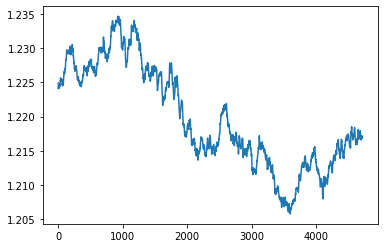

In [34]:
plt.plot(df['sema'])

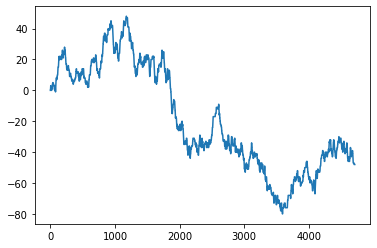

In [36]:
plt.plot(df['cons_dir'])

In [42]:
df[['sema_diff', 'cons_dir', 'cons_dir1']]

,sema_diff,cons_dir,cons_dir1
0,0.00018,0,1
1,0.00024,0,2
2,0.00018,1,3
3,0.00024,2,4
4,0.00012,3,5
...,...,...,...
4710,0.00000,-48,-53
4711,0.00004,-48,-53
4712,0.00006,-48,-53
4713,0.00007,-48,-53
